In [57]:
sample_or_prod = False #True = sample, False = production


In [58]:
from theano.sandbox import cuda

In [59]:
HOMEPATH = "/home/ubuntu/fastai/"

DATA_PATH = HOMEPATH+"data/Kaggle_dogs-vs-cats-redux-kernels-edition/"

MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)


('WORKING_DATA:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/')
('WORKING_TEST:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/test/')
('WORKING_TRAIN:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/')
('WORKING_VALID:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/')
('s_or_p:', '_prod_')


In [60]:
import os
from datetime import datetime
from keras.models import model_from_json

In [61]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

from vgg16 import Vgg16


('os.getcwd:', '/home/ubuntu/fastai')


In [62]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition
.
├── models
│   ├── train_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   └── valid_data_sample_.bc
│       ├── data
│       └── meta
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── valid
│       ├── cat
│       └── dog
├── test
│   └── unknown
├── train
│   ├── cat
│   └── dog
└── valid
    ├── cat
    └── dog

43 directories


In [63]:
CATEGORIES = ['cat/', 'dog/']#nb: do not change order or trailing slash
UNKNOWN = 'unknown/'


In [64]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)


#delete the variables we don't need to prevent accidental use.
del SAMPLE_DATA_PATH
del SAMPLE_TEST_PATH
del SAMPLE_TRAIN_PATH
del SAMPLE_VALID_PATH
del TEST_PATH
del TRAIN_PATH
del VALID_PATH


In [65]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]

In [66]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print dir_, len(dirFileList(dir_))


In [67]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print count, type(layer), ", trainable:", layer.trainable
        print "input:", layer.input_shape, ", output:",layer.output_shape, "\n"
        count +=1

In [68]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [69]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [70]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [71]:
def get_bn_layers(p):
    #create list of layers, use nominated dropout rate.
    #MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [72]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/ 13
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/ 1
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/unknown/ 2500
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/cat/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/dog/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/cat/ 750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/dog/ 75

In [73]:
#make list of files in TEST_PATH
test_files = dirFileList(WORKING_TEST+UNKNOWN)
print "WORKING_TEST+UNKNOWN:", WORKING_TEST+UNKNOWN, len(test_files)

WORKING_TEST+UNKNOWN: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/test/unknown/ 12500


In [74]:
batch_size = 4
print("batch_size:", batch_size)
test_batches = get_batches(WORKING_TEST, batch_size=batch_size)
#NB:get_batches looks after the target_size=(224,224)

('batch_size:', 4)
Found 12500 images belonging to 1 classes.


In [75]:
test_batches.class_indices

{'unknown': 0}

imgs: <type 'numpy.ndarray'> (4, 3, 224, 224)
labels: <type 'numpy.ndarray'> (4, 1)
labels: [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
$ of files in filenames: 12500
filenames: ['unknown/2957.jpg', 'unknown/11706.jpg', 'unknown/10629.jpg', 'unknown/9810.jpg']


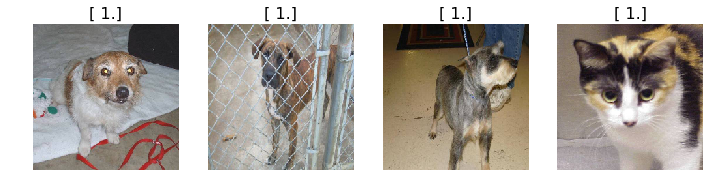

In [76]:
imgs,labels = next(test_batches)
#labels here is a throwaway since test data comes in one category only. ie we have to predict from model.
print "imgs:", type(imgs), imgs.shape
print "labels:", type(labels), labels.shape
print "labels:", labels[0:10]
filenames = test_batches.filenames
print "$ of files in filenames:", len(filenames)
print "filenames:", filenames[0:4]
plots(imgs[0:4], titles=labels[0:4])

In [77]:
#utils:vgg_ft(out_dim)
#creates standard vgg16 model, pops last layer, sets all layers to non-trainable
#model.add(Dense(num, activation='softmax')) and model.compile
model = vgg_ft(2)

In [78]:
layers = model.layers
print "len(layers):", len(layers)

len(layers): 38


In [79]:
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]
print "last_conv_idx:", last_conv_idx
print type(layers[last_conv_idx])

last_conv_idx: 30
<class 'keras.layers.convolutional.Convolution2D'>


In [80]:
#split our model created from vgg_ft(p) into two sets of layers
#conv_layers = layers from start up to and including the last Convolution2D layer 

conv_layers = layers[:last_conv_idx+1]
print "len(conv_layers):", len(conv_layers)

len(conv_layers): 31


In [81]:
bn_layers = get_bn_layers(0.6)
print (len(bn_layers)), ", last layer:", type(bn_layers[-1])
#recall - get_bn_layers : creates list of layers with nominated dropout 
#MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
#remove last layer (which is dense), replace with new layer with two categories. 
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

9 , last layer: <class 'keras.layers.core.Dense'>


In [82]:
#recall : conv_layers = list of first to last Convolution2D layers from vgg_16 model.
final_model = Sequential(conv_layers)
#set layers to non trainable
for layer in final_model.layers: 
    layer.trainable = False
#add layers to final_model to make it a complete vgg_16 set of layers.
for layer in bn_layers: 
    final_model.add(layer)
    
#final_model now has total 40 layers, first 31 layers are non trainable, last 9 layers are trainable.
#first 31 layers are stock vgg16, (layers from start up to and including the last Convolution2D layer)
# last 9 layers are MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
# with dropout rate of 0.6 - created by get_bn_layers. 
#last layer set to Dense(2,activation='softmax') = 2 categories for dog/cat.
#starts with weights from lesson2.

In [83]:
showLayersInfo(final_model)

('Number of layers : ', 40)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [84]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
                                                                   zeropadding2d_14[1][0]           
___________________________________________________________________________________________

convolution2d_26 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_26[0][0]           
                                                                   zeropadding2d_26[1][0]           
____________________________________________________________________________________________________
maxpooling2d_12 (MaxPooling2D)   (None, 512, 7, 7)     0           convolution2d_26[1][0]           
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 25088)         0           maxpooling2d_12[0][0]            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 4096)          102764544   flatten_4[0][0]                  
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 4096)          16384       dense_13[0][0]          

In [85]:
print MODEL_PATH + 'final_model_3'+s_or_p+'.h5'

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/final_model_3_prod_.h5


In [86]:

# load weights into new model
final_model.load_weights(MODEL_PATH + 'final_model_3'+s_or_p+'.h5')
print("Loaded model from disk")

Loaded model from disk


In [87]:
startTime= datetime.now()
print ("startTime:", startTime)

num_batches = int(len(filenames)/batch_size)
#nb: for this case above works since len(filenames) is a multiple of batch_size
#NBB: need to check generic fix for this.
print("num_batches:", num_batches)
preds = final_model.predict(imgs)#preds: <type 'numpy.ndarray'> (4, 2)  float values
pred_classes = final_model.predict_classes(imgs)#<type 'numpy.ndarray'> (4,) int values

for i in range(0, num_batches-1):
    imgs,labels = next(test_batches)
    preds        = np.vstack((preds,        final_model.predict(imgs) )) #preds: <type 'numpy.ndarray'> (4, 2)  float values
    pred_classes = np.hstack((pred_classes, final_model.predict_classes(imgs) ))#<type 'numpy.ndarray'> (4,) int values
    print("preds.shape:", preds.shape, ", pred_classes:", pred_classes.shape)
    #pred_classes = final_model.predict_classes(imgs)  

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


('startTime:', datetime.datetime(2017, 12, 19, 22, 35, 2, 25758))
('num_batches:', 3125)
4/4 [==============================] - 0s
('preds.shape:', (8, 2), ', pred_classes:', (8,))
4/4 [==============================] - 0s
('preds.shape:', (12, 2), ', pred_classes:', (12,))
4/4 [==============================] - 0s
('preds.shape:', (16, 2), ', pred_classes:', (16,))
4/4 [==============================] - 0s
('preds.shape:', (20, 2), ', pred_classes:', (20,))
4/4 [==============================] - 0s
('preds.shape:', (24, 2), ', pred_classes:', (24,))
4/4 [==============================] - 0s
('preds.shape:', (28, 2), ', pred_classes:', (28,))
4/4 [==============================] - 0s
('preds.shape:', (32, 2), ', pred_classes:', (32,))
4/4 [==============================] - 0s
('preds.shape:', (36, 2), ', pred_classes:', (36,))
4/4 [==============================] - 0s
('preds.shape:', (40, 2), ', pred_classes:', (40,))
4/4 [==============================] - 0s
('preds.shape:', (44, 2),

4/4 [==============================] - 0s
('preds.shape:', (348, 2), ', pred_classes:', (348,))
4/4 [==============================] - 0s
('preds.shape:', (352, 2), ', pred_classes:', (352,))
4/4 [==============================] - 0s
('preds.shape:', (356, 2), ', pred_classes:', (356,))
4/4 [==============================] - 0s
('preds.shape:', (360, 2), ', pred_classes:', (360,))
4/4 [==============================] - 0s
('preds.shape:', (364, 2), ', pred_classes:', (364,))
4/4 [==============================] - 0s
('preds.shape:', (368, 2), ', pred_classes:', (368,))
4/4 [==============================] - 0s
('preds.shape:', (372, 2), ', pred_classes:', (372,))
4/4 [==============================] - 0s
('preds.shape:', (376, 2), ', pred_classes:', (376,))
4/4 [==============================] - 0s
('preds.shape:', (380, 2), ', pred_classes:', (380,))
4/4 [==============================] - 0s
('preds.shape:', (384, 2), ', pred_classes:', (384,))
4/4 [==============================] - 0

4/4 [==============================] - 0s
('preds.shape:', (688, 2), ', pred_classes:', (688,))
4/4 [==============================] - 0s
('preds.shape:', (692, 2), ', pred_classes:', (692,))
4/4 [==============================] - 0s
('preds.shape:', (696, 2), ', pred_classes:', (696,))
4/4 [==============================] - 0s
('preds.shape:', (700, 2), ', pred_classes:', (700,))
4/4 [==============================] - 0s
('preds.shape:', (704, 2), ', pred_classes:', (704,))
4/4 [==============================] - 0s
('preds.shape:', (708, 2), ', pred_classes:', (708,))
4/4 [==============================] - 0s
('preds.shape:', (712, 2), ', pred_classes:', (712,))
4/4 [==============================] - 0s
('preds.shape:', (716, 2), ', pred_classes:', (716,))
4/4 [==============================] - 0s
('preds.shape:', (720, 2), ', pred_classes:', (720,))
4/4 [==============================] - 0s
('preds.shape:', (724, 2), ', pred_classes:', (724,))
4/4 [==============================] - 0

4/4 [==============================] - 0s
('preds.shape:', (1028, 2), ', pred_classes:', (1028,))
4/4 [==============================] - 0s
('preds.shape:', (1032, 2), ', pred_classes:', (1032,))
4/4 [==============================] - 0s
('preds.shape:', (1036, 2), ', pred_classes:', (1036,))
4/4 [==============================] - 0s
('preds.shape:', (1040, 2), ', pred_classes:', (1040,))
4/4 [==============================] - 0s
('preds.shape:', (1044, 2), ', pred_classes:', (1044,))
4/4 [==============================] - 0s
('preds.shape:', (1048, 2), ', pred_classes:', (1048,))
4/4 [==============================] - 0s
('preds.shape:', (1052, 2), ', pred_classes:', (1052,))
4/4 [==============================] - 0s
('preds.shape:', (1056, 2), ', pred_classes:', (1056,))
4/4 [==============================] - 0s
('preds.shape:', (1060, 2), ', pred_classes:', (1060,))
4/4 [==============================] - 0s
('preds.shape:', (1064, 2), ', pred_classes:', (1064,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (1364, 2), ', pred_classes:', (1364,))
4/4 [==============================] - 0s
('preds.shape:', (1368, 2), ', pred_classes:', (1368,))
4/4 [==============================] - 0s
('preds.shape:', (1372, 2), ', pred_classes:', (1372,))
4/4 [==============================] - 0s
('preds.shape:', (1376, 2), ', pred_classes:', (1376,))
4/4 [==============================] - 0s
('preds.shape:', (1380, 2), ', pred_classes:', (1380,))
4/4 [==============================] - 0s
('preds.shape:', (1384, 2), ', pred_classes:', (1384,))
4/4 [==============================] - 0s
('preds.shape:', (1388, 2), ', pred_classes:', (1388,))
4/4 [==============================] - 0s
('preds.shape:', (1392, 2), ', pred_classes:', (1392,))
4/4 [==============================] - 0s
('preds.shape:', (1396, 2), ', pred_classes:', (1396,))
4/4 [==============================] - 0s
('preds.shape:', (1400, 2), ', pred_classes:', (1400,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (1700, 2), ', pred_classes:', (1700,))
4/4 [==============================] - 0s
('preds.shape:', (1704, 2), ', pred_classes:', (1704,))
4/4 [==============================] - 0s
('preds.shape:', (1708, 2), ', pred_classes:', (1708,))
4/4 [==============================] - 0s
('preds.shape:', (1712, 2), ', pred_classes:', (1712,))
4/4 [==============================] - 0s
('preds.shape:', (1716, 2), ', pred_classes:', (1716,))
4/4 [==============================] - 0s
('preds.shape:', (1720, 2), ', pred_classes:', (1720,))
4/4 [==============================] - 0s
('preds.shape:', (1724, 2), ', pred_classes:', (1724,))
4/4 [==============================] - 0s
('preds.shape:', (1728, 2), ', pred_classes:', (1728,))
4/4 [==============================] - 0s
('preds.shape:', (1732, 2), ', pred_classes:', (1732,))
4/4 [==============================] - 0s
('preds.shape:', (1736, 2), ', pred_classes:', (1736,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (2036, 2), ', pred_classes:', (2036,))
4/4 [==============================] - 0s
('preds.shape:', (2040, 2), ', pred_classes:', (2040,))
4/4 [==============================] - 0s
('preds.shape:', (2044, 2), ', pred_classes:', (2044,))
4/4 [==============================] - 0s
('preds.shape:', (2048, 2), ', pred_classes:', (2048,))
4/4 [==============================] - 0s
('preds.shape:', (2052, 2), ', pred_classes:', (2052,))
4/4 [==============================] - 0s
('preds.shape:', (2056, 2), ', pred_classes:', (2056,))
4/4 [==============================] - 0s
('preds.shape:', (2060, 2), ', pred_classes:', (2060,))
4/4 [==============================] - 0s
('preds.shape:', (2064, 2), ', pred_classes:', (2064,))
4/4 [==============================] - 0s
('preds.shape:', (2068, 2), ', pred_classes:', (2068,))
4/4 [==============================] - 0s
('preds.shape:', (2072, 2), ', pred_classes:', (2072,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (2372, 2), ', pred_classes:', (2372,))
4/4 [==============================] - 0s
('preds.shape:', (2376, 2), ', pred_classes:', (2376,))
4/4 [==============================] - 0s
('preds.shape:', (2380, 2), ', pred_classes:', (2380,))
4/4 [==============================] - 0s
('preds.shape:', (2384, 2), ', pred_classes:', (2384,))
4/4 [==============================] - 0s
('preds.shape:', (2388, 2), ', pred_classes:', (2388,))
4/4 [==============================] - 0s
('preds.shape:', (2392, 2), ', pred_classes:', (2392,))
4/4 [==============================] - 0s
('preds.shape:', (2396, 2), ', pred_classes:', (2396,))
4/4 [==============================] - 0s
('preds.shape:', (2400, 2), ', pred_classes:', (2400,))
4/4 [==============================] - 0s
('preds.shape:', (2404, 2), ', pred_classes:', (2404,))
4/4 [==============================] - 0s
('preds.shape:', (2408, 2), ', pred_classes:', (2408,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (2708, 2), ', pred_classes:', (2708,))
4/4 [==============================] - 0s
('preds.shape:', (2712, 2), ', pred_classes:', (2712,))
4/4 [==============================] - 0s
('preds.shape:', (2716, 2), ', pred_classes:', (2716,))
4/4 [==============================] - 0s
('preds.shape:', (2720, 2), ', pred_classes:', (2720,))
4/4 [==============================] - 0s
('preds.shape:', (2724, 2), ', pred_classes:', (2724,))
4/4 [==============================] - 0s
('preds.shape:', (2728, 2), ', pred_classes:', (2728,))
4/4 [==============================] - 0s
('preds.shape:', (2732, 2), ', pred_classes:', (2732,))
4/4 [==============================] - 0s
('preds.shape:', (2736, 2), ', pred_classes:', (2736,))
4/4 [==============================] - 0s
('preds.shape:', (2740, 2), ', pred_classes:', (2740,))
4/4 [==============================] - 0s
('preds.shape:', (2744, 2), ', pred_classes:', (2744,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (3044, 2), ', pred_classes:', (3044,))
4/4 [==============================] - 0s
('preds.shape:', (3048, 2), ', pred_classes:', (3048,))
4/4 [==============================] - 0s
('preds.shape:', (3052, 2), ', pred_classes:', (3052,))
4/4 [==============================] - 0s
('preds.shape:', (3056, 2), ', pred_classes:', (3056,))
4/4 [==============================] - 0s
('preds.shape:', (3060, 2), ', pred_classes:', (3060,))
4/4 [==============================] - 0s
('preds.shape:', (3064, 2), ', pred_classes:', (3064,))
4/4 [==============================] - 0s
('preds.shape:', (3068, 2), ', pred_classes:', (3068,))
4/4 [==============================] - 0s
('preds.shape:', (3072, 2), ', pred_classes:', (3072,))
4/4 [==============================] - 0s
('preds.shape:', (3076, 2), ', pred_classes:', (3076,))
4/4 [==============================] - 0s
('preds.shape:', (3080, 2), ', pred_classes:', (3080,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (3380, 2), ', pred_classes:', (3380,))
4/4 [==============================] - 0s
('preds.shape:', (3384, 2), ', pred_classes:', (3384,))
4/4 [==============================] - 0s
('preds.shape:', (3388, 2), ', pred_classes:', (3388,))
4/4 [==============================] - 0s
('preds.shape:', (3392, 2), ', pred_classes:', (3392,))
4/4 [==============================] - 0s
('preds.shape:', (3396, 2), ', pred_classes:', (3396,))
4/4 [==============================] - 0s
('preds.shape:', (3400, 2), ', pred_classes:', (3400,))
4/4 [==============================] - 0s
('preds.shape:', (3404, 2), ', pred_classes:', (3404,))
4/4 [==============================] - 0s
('preds.shape:', (3408, 2), ', pred_classes:', (3408,))
4/4 [==============================] - 0s
('preds.shape:', (3412, 2), ', pred_classes:', (3412,))
4/4 [==============================] - 0s
('preds.shape:', (3416, 2), ', pred_classes:', (3416,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (3716, 2), ', pred_classes:', (3716,))
4/4 [==============================] - 0s
('preds.shape:', (3720, 2), ', pred_classes:', (3720,))
4/4 [==============================] - 0s
('preds.shape:', (3724, 2), ', pred_classes:', (3724,))
4/4 [==============================] - 0s
('preds.shape:', (3728, 2), ', pred_classes:', (3728,))
4/4 [==============================] - 0s
('preds.shape:', (3732, 2), ', pred_classes:', (3732,))
4/4 [==============================] - 0s
('preds.shape:', (3736, 2), ', pred_classes:', (3736,))
4/4 [==============================] - 0s
('preds.shape:', (3740, 2), ', pred_classes:', (3740,))
4/4 [==============================] - 0s
('preds.shape:', (3744, 2), ', pred_classes:', (3744,))
4/4 [==============================] - 0s
('preds.shape:', (3748, 2), ', pred_classes:', (3748,))
4/4 [==============================] - 0s
('preds.shape:', (3752, 2), ', pred_classes:', (3752,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (4052, 2), ', pred_classes:', (4052,))
4/4 [==============================] - 0s
('preds.shape:', (4056, 2), ', pred_classes:', (4056,))
4/4 [==============================] - 0s
('preds.shape:', (4060, 2), ', pred_classes:', (4060,))
4/4 [==============================] - 0s
('preds.shape:', (4064, 2), ', pred_classes:', (4064,))
4/4 [==============================] - 0s
('preds.shape:', (4068, 2), ', pred_classes:', (4068,))
4/4 [==============================] - 0s
('preds.shape:', (4072, 2), ', pred_classes:', (4072,))
4/4 [==============================] - 0s
('preds.shape:', (4076, 2), ', pred_classes:', (4076,))
4/4 [==============================] - 0s
('preds.shape:', (4080, 2), ', pred_classes:', (4080,))
4/4 [==============================] - 0s
('preds.shape:', (4084, 2), ', pred_classes:', (4084,))
4/4 [==============================] - 0s
('preds.shape:', (4088, 2), ', pred_classes:', (4088,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (4388, 2), ', pred_classes:', (4388,))
4/4 [==============================] - 0s
('preds.shape:', (4392, 2), ', pred_classes:', (4392,))
4/4 [==============================] - 0s
('preds.shape:', (4396, 2), ', pred_classes:', (4396,))
4/4 [==============================] - 0s
('preds.shape:', (4400, 2), ', pred_classes:', (4400,))
4/4 [==============================] - 0s
('preds.shape:', (4404, 2), ', pred_classes:', (4404,))
4/4 [==============================] - 0s
('preds.shape:', (4408, 2), ', pred_classes:', (4408,))
4/4 [==============================] - 0s
('preds.shape:', (4412, 2), ', pred_classes:', (4412,))
4/4 [==============================] - 0s
('preds.shape:', (4416, 2), ', pred_classes:', (4416,))
4/4 [==============================] - 0s
('preds.shape:', (4420, 2), ', pred_classes:', (4420,))
4/4 [==============================] - 0s
('preds.shape:', (4424, 2), ', pred_classes:', (4424,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (4724, 2), ', pred_classes:', (4724,))
4/4 [==============================] - 0s
('preds.shape:', (4728, 2), ', pred_classes:', (4728,))
4/4 [==============================] - 0s
('preds.shape:', (4732, 2), ', pred_classes:', (4732,))
4/4 [==============================] - 0s
('preds.shape:', (4736, 2), ', pred_classes:', (4736,))
4/4 [==============================] - 0s
('preds.shape:', (4740, 2), ', pred_classes:', (4740,))
4/4 [==============================] - 0s
('preds.shape:', (4744, 2), ', pred_classes:', (4744,))
4/4 [==============================] - 0s
('preds.shape:', (4748, 2), ', pred_classes:', (4748,))
4/4 [==============================] - 0s
('preds.shape:', (4752, 2), ', pred_classes:', (4752,))
4/4 [==============================] - 0s
('preds.shape:', (4756, 2), ', pred_classes:', (4756,))
4/4 [==============================] - 0s
('preds.shape:', (4760, 2), ', pred_classes:', (4760,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (5060, 2), ', pred_classes:', (5060,))
4/4 [==============================] - 0s
('preds.shape:', (5064, 2), ', pred_classes:', (5064,))
4/4 [==============================] - 0s
('preds.shape:', (5068, 2), ', pred_classes:', (5068,))
4/4 [==============================] - 0s
('preds.shape:', (5072, 2), ', pred_classes:', (5072,))
4/4 [==============================] - 0s
('preds.shape:', (5076, 2), ', pred_classes:', (5076,))
4/4 [==============================] - 0s
('preds.shape:', (5080, 2), ', pred_classes:', (5080,))
4/4 [==============================] - 0s
('preds.shape:', (5084, 2), ', pred_classes:', (5084,))
4/4 [==============================] - 0s
('preds.shape:', (5088, 2), ', pred_classes:', (5088,))
4/4 [==============================] - 0s
('preds.shape:', (5092, 2), ', pred_classes:', (5092,))
4/4 [==============================] - 0s
('preds.shape:', (5096, 2), ', pred_classes:', (5096,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (5396, 2), ', pred_classes:', (5396,))
4/4 [==============================] - 0s
('preds.shape:', (5400, 2), ', pred_classes:', (5400,))
4/4 [==============================] - 0s
('preds.shape:', (5404, 2), ', pred_classes:', (5404,))
4/4 [==============================] - 0s
('preds.shape:', (5408, 2), ', pred_classes:', (5408,))
4/4 [==============================] - 0s
('preds.shape:', (5412, 2), ', pred_classes:', (5412,))
4/4 [==============================] - 0s
('preds.shape:', (5416, 2), ', pred_classes:', (5416,))
4/4 [==============================] - 0s
('preds.shape:', (5420, 2), ', pred_classes:', (5420,))
4/4 [==============================] - 0s
('preds.shape:', (5424, 2), ', pred_classes:', (5424,))
4/4 [==============================] - 0s
('preds.shape:', (5428, 2), ', pred_classes:', (5428,))
4/4 [==============================] - 0s
('preds.shape:', (5432, 2), ', pred_classes:', (5432,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (5732, 2), ', pred_classes:', (5732,))
4/4 [==============================] - 0s
('preds.shape:', (5736, 2), ', pred_classes:', (5736,))
4/4 [==============================] - 0s
('preds.shape:', (5740, 2), ', pred_classes:', (5740,))
4/4 [==============================] - 0s
('preds.shape:', (5744, 2), ', pred_classes:', (5744,))
4/4 [==============================] - 0s
('preds.shape:', (5748, 2), ', pred_classes:', (5748,))
4/4 [==============================] - 0s
('preds.shape:', (5752, 2), ', pred_classes:', (5752,))
4/4 [==============================] - 0s
('preds.shape:', (5756, 2), ', pred_classes:', (5756,))
4/4 [==============================] - 0s
('preds.shape:', (5760, 2), ', pred_classes:', (5760,))
4/4 [==============================] - 0s
('preds.shape:', (5764, 2), ', pred_classes:', (5764,))
4/4 [==============================] - 0s
('preds.shape:', (5768, 2), ', pred_classes:', (5768,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (6068, 2), ', pred_classes:', (6068,))
4/4 [==============================] - 0s
('preds.shape:', (6072, 2), ', pred_classes:', (6072,))
4/4 [==============================] - 0s
('preds.shape:', (6076, 2), ', pred_classes:', (6076,))
4/4 [==============================] - 0s
('preds.shape:', (6080, 2), ', pred_classes:', (6080,))
4/4 [==============================] - 0s
('preds.shape:', (6084, 2), ', pred_classes:', (6084,))
4/4 [==============================] - 0s
('preds.shape:', (6088, 2), ', pred_classes:', (6088,))
4/4 [==============================] - 0s
('preds.shape:', (6092, 2), ', pred_classes:', (6092,))
4/4 [==============================] - 0s
('preds.shape:', (6096, 2), ', pred_classes:', (6096,))
4/4 [==============================] - 0s
('preds.shape:', (6100, 2), ', pred_classes:', (6100,))
4/4 [==============================] - 0s
('preds.shape:', (6104, 2), ', pred_classes:', (6104,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (6404, 2), ', pred_classes:', (6404,))
4/4 [==============================] - 0s
('preds.shape:', (6408, 2), ', pred_classes:', (6408,))
4/4 [==============================] - 0s
('preds.shape:', (6412, 2), ', pred_classes:', (6412,))
4/4 [==============================] - 0s
('preds.shape:', (6416, 2), ', pred_classes:', (6416,))
4/4 [==============================] - 0s
('preds.shape:', (6420, 2), ', pred_classes:', (6420,))
4/4 [==============================] - 0s
('preds.shape:', (6424, 2), ', pred_classes:', (6424,))
4/4 [==============================] - 0s
('preds.shape:', (6428, 2), ', pred_classes:', (6428,))
4/4 [==============================] - 0s
('preds.shape:', (6432, 2), ', pred_classes:', (6432,))
4/4 [==============================] - 0s
('preds.shape:', (6436, 2), ', pred_classes:', (6436,))
4/4 [==============================] - 0s
('preds.shape:', (6440, 2), ', pred_classes:', (6440,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (6740, 2), ', pred_classes:', (6740,))
4/4 [==============================] - 0s
('preds.shape:', (6744, 2), ', pred_classes:', (6744,))
4/4 [==============================] - 0s
('preds.shape:', (6748, 2), ', pred_classes:', (6748,))
4/4 [==============================] - 0s
('preds.shape:', (6752, 2), ', pred_classes:', (6752,))
4/4 [==============================] - 0s
('preds.shape:', (6756, 2), ', pred_classes:', (6756,))
4/4 [==============================] - 0s
('preds.shape:', (6760, 2), ', pred_classes:', (6760,))
4/4 [==============================] - 0s
('preds.shape:', (6764, 2), ', pred_classes:', (6764,))
4/4 [==============================] - 0s
('preds.shape:', (6768, 2), ', pred_classes:', (6768,))
4/4 [==============================] - 0s
('preds.shape:', (6772, 2), ', pred_classes:', (6772,))
4/4 [==============================] - 0s
('preds.shape:', (6776, 2), ', pred_classes:', (6776,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (7076, 2), ', pred_classes:', (7076,))
4/4 [==============================] - 0s
('preds.shape:', (7080, 2), ', pred_classes:', (7080,))
4/4 [==============================] - 0s
('preds.shape:', (7084, 2), ', pred_classes:', (7084,))
4/4 [==============================] - 0s
('preds.shape:', (7088, 2), ', pred_classes:', (7088,))
4/4 [==============================] - 0s
('preds.shape:', (7092, 2), ', pred_classes:', (7092,))
4/4 [==============================] - 0s
('preds.shape:', (7096, 2), ', pred_classes:', (7096,))
4/4 [==============================] - 0s
('preds.shape:', (7100, 2), ', pred_classes:', (7100,))
4/4 [==============================] - 0s
('preds.shape:', (7104, 2), ', pred_classes:', (7104,))
4/4 [==============================] - 0s
('preds.shape:', (7108, 2), ', pred_classes:', (7108,))
4/4 [==============================] - 0s
('preds.shape:', (7112, 2), ', pred_classes:', (7112,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (7412, 2), ', pred_classes:', (7412,))
4/4 [==============================] - 0s
('preds.shape:', (7416, 2), ', pred_classes:', (7416,))
4/4 [==============================] - 0s
('preds.shape:', (7420, 2), ', pred_classes:', (7420,))
4/4 [==============================] - 0s
('preds.shape:', (7424, 2), ', pred_classes:', (7424,))
4/4 [==============================] - 0s
('preds.shape:', (7428, 2), ', pred_classes:', (7428,))
4/4 [==============================] - 0s
('preds.shape:', (7432, 2), ', pred_classes:', (7432,))
4/4 [==============================] - 0s
('preds.shape:', (7436, 2), ', pred_classes:', (7436,))
4/4 [==============================] - 0s
('preds.shape:', (7440, 2), ', pred_classes:', (7440,))
4/4 [==============================] - 0s
('preds.shape:', (7444, 2), ', pred_classes:', (7444,))
4/4 [==============================] - 0s
('preds.shape:', (7448, 2), ', pred_classes:', (7448,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (7748, 2), ', pred_classes:', (7748,))
4/4 [==============================] - 0s
('preds.shape:', (7752, 2), ', pred_classes:', (7752,))
4/4 [==============================] - 0s
('preds.shape:', (7756, 2), ', pred_classes:', (7756,))
4/4 [==============================] - 0s
('preds.shape:', (7760, 2), ', pred_classes:', (7760,))
4/4 [==============================] - 0s
('preds.shape:', (7764, 2), ', pred_classes:', (7764,))
4/4 [==============================] - 0s
('preds.shape:', (7768, 2), ', pred_classes:', (7768,))
4/4 [==============================] - 0s
('preds.shape:', (7772, 2), ', pred_classes:', (7772,))
4/4 [==============================] - 0s
('preds.shape:', (7776, 2), ', pred_classes:', (7776,))
4/4 [==============================] - 0s
('preds.shape:', (7780, 2), ', pred_classes:', (7780,))
4/4 [==============================] - 0s
('preds.shape:', (7784, 2), ', pred_classes:', (7784,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (8084, 2), ', pred_classes:', (8084,))
4/4 [==============================] - 0s
('preds.shape:', (8088, 2), ', pred_classes:', (8088,))
4/4 [==============================] - 0s
('preds.shape:', (8092, 2), ', pred_classes:', (8092,))
4/4 [==============================] - 0s
('preds.shape:', (8096, 2), ', pred_classes:', (8096,))
4/4 [==============================] - 0s
('preds.shape:', (8100, 2), ', pred_classes:', (8100,))
4/4 [==============================] - 0s
('preds.shape:', (8104, 2), ', pred_classes:', (8104,))
4/4 [==============================] - 0s
('preds.shape:', (8108, 2), ', pred_classes:', (8108,))
4/4 [==============================] - 0s
('preds.shape:', (8112, 2), ', pred_classes:', (8112,))
4/4 [==============================] - 0s
('preds.shape:', (8116, 2), ', pred_classes:', (8116,))
4/4 [==============================] - 0s
('preds.shape:', (8120, 2), ', pred_classes:', (8120,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (8420, 2), ', pred_classes:', (8420,))
4/4 [==============================] - 0s
('preds.shape:', (8424, 2), ', pred_classes:', (8424,))
4/4 [==============================] - 0s
('preds.shape:', (8428, 2), ', pred_classes:', (8428,))
4/4 [==============================] - 0s
('preds.shape:', (8432, 2), ', pred_classes:', (8432,))
4/4 [==============================] - 0s
('preds.shape:', (8436, 2), ', pred_classes:', (8436,))
4/4 [==============================] - 0s
('preds.shape:', (8440, 2), ', pred_classes:', (8440,))
4/4 [==============================] - 0s
('preds.shape:', (8444, 2), ', pred_classes:', (8444,))
4/4 [==============================] - 0s
('preds.shape:', (8448, 2), ', pred_classes:', (8448,))
4/4 [==============================] - 0s
('preds.shape:', (8452, 2), ', pred_classes:', (8452,))
4/4 [==============================] - 0s
('preds.shape:', (8456, 2), ', pred_classes:', (8456,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (8756, 2), ', pred_classes:', (8756,))
4/4 [==============================] - 0s
('preds.shape:', (8760, 2), ', pred_classes:', (8760,))
4/4 [==============================] - 0s
('preds.shape:', (8764, 2), ', pred_classes:', (8764,))
4/4 [==============================] - 0s
('preds.shape:', (8768, 2), ', pred_classes:', (8768,))
4/4 [==============================] - 0s
('preds.shape:', (8772, 2), ', pred_classes:', (8772,))
4/4 [==============================] - 0s
('preds.shape:', (8776, 2), ', pred_classes:', (8776,))
4/4 [==============================] - 0s
('preds.shape:', (8780, 2), ', pred_classes:', (8780,))
4/4 [==============================] - 0s
('preds.shape:', (8784, 2), ', pred_classes:', (8784,))
4/4 [==============================] - 0s
('preds.shape:', (8788, 2), ', pred_classes:', (8788,))
4/4 [==============================] - 0s
('preds.shape:', (8792, 2), ', pred_classes:', (8792,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (9092, 2), ', pred_classes:', (9092,))
4/4 [==============================] - 0s
('preds.shape:', (9096, 2), ', pred_classes:', (9096,))
4/4 [==============================] - 0s
('preds.shape:', (9100, 2), ', pred_classes:', (9100,))
4/4 [==============================] - 0s
('preds.shape:', (9104, 2), ', pred_classes:', (9104,))
4/4 [==============================] - 0s
('preds.shape:', (9108, 2), ', pred_classes:', (9108,))
4/4 [==============================] - 0s
('preds.shape:', (9112, 2), ', pred_classes:', (9112,))
4/4 [==============================] - 0s
('preds.shape:', (9116, 2), ', pred_classes:', (9116,))
4/4 [==============================] - 0s
('preds.shape:', (9120, 2), ', pred_classes:', (9120,))
4/4 [==============================] - 0s
('preds.shape:', (9124, 2), ', pred_classes:', (9124,))
4/4 [==============================] - 0s
('preds.shape:', (9128, 2), ', pred_classes:', (9128,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (9428, 2), ', pred_classes:', (9428,))
4/4 [==============================] - 0s
('preds.shape:', (9432, 2), ', pred_classes:', (9432,))
4/4 [==============================] - 0s
('preds.shape:', (9436, 2), ', pred_classes:', (9436,))
4/4 [==============================] - 0s
('preds.shape:', (9440, 2), ', pred_classes:', (9440,))
4/4 [==============================] - 0s
('preds.shape:', (9444, 2), ', pred_classes:', (9444,))
4/4 [==============================] - 0s
('preds.shape:', (9448, 2), ', pred_classes:', (9448,))
4/4 [==============================] - 0s
('preds.shape:', (9452, 2), ', pred_classes:', (9452,))
4/4 [==============================] - 0s
('preds.shape:', (9456, 2), ', pred_classes:', (9456,))
4/4 [==============================] - 0s
('preds.shape:', (9460, 2), ', pred_classes:', (9460,))
4/4 [==============================] - 0s
('preds.shape:', (9464, 2), ', pred_classes:', (9464,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (9764, 2), ', pred_classes:', (9764,))
4/4 [==============================] - 0s
('preds.shape:', (9768, 2), ', pred_classes:', (9768,))
4/4 [==============================] - 0s
('preds.shape:', (9772, 2), ', pred_classes:', (9772,))
4/4 [==============================] - 0s
('preds.shape:', (9776, 2), ', pred_classes:', (9776,))
4/4 [==============================] - 0s
('preds.shape:', (9780, 2), ', pred_classes:', (9780,))
4/4 [==============================] - 0s
('preds.shape:', (9784, 2), ', pred_classes:', (9784,))
4/4 [==============================] - 0s
('preds.shape:', (9788, 2), ', pred_classes:', (9788,))
4/4 [==============================] - 0s
('preds.shape:', (9792, 2), ', pred_classes:', (9792,))
4/4 [==============================] - 0s
('preds.shape:', (9796, 2), ', pred_classes:', (9796,))
4/4 [==============================] - 0s
('preds.shape:', (9800, 2), ', pred_classes:', (9800,))
4/4 [===============

4/4 [==============================] - 0s
('preds.shape:', (10096, 2), ', pred_classes:', (10096,))
4/4 [==============================] - 0s
('preds.shape:', (10100, 2), ', pred_classes:', (10100,))
4/4 [==============================] - 0s
('preds.shape:', (10104, 2), ', pred_classes:', (10104,))
4/4 [==============================] - 0s
('preds.shape:', (10108, 2), ', pred_classes:', (10108,))
4/4 [==============================] - 0s
('preds.shape:', (10112, 2), ', pred_classes:', (10112,))
4/4 [==============================] - 0s
('preds.shape:', (10116, 2), ', pred_classes:', (10116,))
4/4 [==============================] - 0s
('preds.shape:', (10120, 2), ', pred_classes:', (10120,))
4/4 [==============================] - 0s
('preds.shape:', (10124, 2), ', pred_classes:', (10124,))
4/4 [==============================] - 0s
('preds.shape:', (10128, 2), ', pred_classes:', (10128,))
4/4 [==============================] - 0s
('preds.shape:', (10132, 2), ', pred_classes:', (10132,))


4/4 [==============================] - 0s
('preds.shape:', (10424, 2), ', pred_classes:', (10424,))
4/4 [==============================] - 0s
('preds.shape:', (10428, 2), ', pred_classes:', (10428,))
4/4 [==============================] - 0s
('preds.shape:', (10432, 2), ', pred_classes:', (10432,))
4/4 [==============================] - 0s
('preds.shape:', (10436, 2), ', pred_classes:', (10436,))
4/4 [==============================] - 0s
('preds.shape:', (10440, 2), ', pred_classes:', (10440,))
4/4 [==============================] - 0s
('preds.shape:', (10444, 2), ', pred_classes:', (10444,))
4/4 [==============================] - 0s
('preds.shape:', (10448, 2), ', pred_classes:', (10448,))
4/4 [==============================] - 0s
('preds.shape:', (10452, 2), ', pred_classes:', (10452,))
4/4 [==============================] - 0s
('preds.shape:', (10456, 2), ', pred_classes:', (10456,))
4/4 [==============================] - 0s
('preds.shape:', (10460, 2), ', pred_classes:', (10460,))


4/4 [==============================] - 0s
('preds.shape:', (10752, 2), ', pred_classes:', (10752,))
4/4 [==============================] - 0s
('preds.shape:', (10756, 2), ', pred_classes:', (10756,))
4/4 [==============================] - 0s
('preds.shape:', (10760, 2), ', pred_classes:', (10760,))
4/4 [==============================] - 0s
('preds.shape:', (10764, 2), ', pred_classes:', (10764,))
4/4 [==============================] - 0s
('preds.shape:', (10768, 2), ', pred_classes:', (10768,))
4/4 [==============================] - 0s
('preds.shape:', (10772, 2), ', pred_classes:', (10772,))
4/4 [==============================] - 0s
('preds.shape:', (10776, 2), ', pred_classes:', (10776,))
4/4 [==============================] - 0s
('preds.shape:', (10780, 2), ', pred_classes:', (10780,))
4/4 [==============================] - 0s
('preds.shape:', (10784, 2), ', pred_classes:', (10784,))
4/4 [==============================] - 0s
('preds.shape:', (10788, 2), ', pred_classes:', (10788,))


4/4 [==============================] - 0s
('preds.shape:', (11080, 2), ', pred_classes:', (11080,))
4/4 [==============================] - 0s
('preds.shape:', (11084, 2), ', pred_classes:', (11084,))
4/4 [==============================] - 0s
('preds.shape:', (11088, 2), ', pred_classes:', (11088,))
4/4 [==============================] - 0s
('preds.shape:', (11092, 2), ', pred_classes:', (11092,))
4/4 [==============================] - 0s
('preds.shape:', (11096, 2), ', pred_classes:', (11096,))
4/4 [==============================] - 0s
('preds.shape:', (11100, 2), ', pred_classes:', (11100,))
4/4 [==============================] - 0s
('preds.shape:', (11104, 2), ', pred_classes:', (11104,))
4/4 [==============================] - 0s
('preds.shape:', (11108, 2), ', pred_classes:', (11108,))
4/4 [==============================] - 0s
('preds.shape:', (11112, 2), ', pred_classes:', (11112,))
4/4 [==============================] - 0s
('preds.shape:', (11116, 2), ', pred_classes:', (11116,))


4/4 [==============================] - 0s
('preds.shape:', (11408, 2), ', pred_classes:', (11408,))
4/4 [==============================] - 0s
('preds.shape:', (11412, 2), ', pred_classes:', (11412,))
4/4 [==============================] - 0s
('preds.shape:', (11416, 2), ', pred_classes:', (11416,))
4/4 [==============================] - 0s
('preds.shape:', (11420, 2), ', pred_classes:', (11420,))
4/4 [==============================] - 0s
('preds.shape:', (11424, 2), ', pred_classes:', (11424,))
4/4 [==============================] - 0s
('preds.shape:', (11428, 2), ', pred_classes:', (11428,))
4/4 [==============================] - 0s
('preds.shape:', (11432, 2), ', pred_classes:', (11432,))
4/4 [==============================] - 0s
('preds.shape:', (11436, 2), ', pred_classes:', (11436,))
4/4 [==============================] - 0s
('preds.shape:', (11440, 2), ', pred_classes:', (11440,))
4/4 [==============================] - 0s
('preds.shape:', (11444, 2), ', pred_classes:', (11444,))


4/4 [==============================] - 0s
('preds.shape:', (11736, 2), ', pred_classes:', (11736,))
4/4 [==============================] - 0s
('preds.shape:', (11740, 2), ', pred_classes:', (11740,))
4/4 [==============================] - 0s
('preds.shape:', (11744, 2), ', pred_classes:', (11744,))
4/4 [==============================] - 0s
('preds.shape:', (11748, 2), ', pred_classes:', (11748,))
4/4 [==============================] - 0s
('preds.shape:', (11752, 2), ', pred_classes:', (11752,))
4/4 [==============================] - 0s
('preds.shape:', (11756, 2), ', pred_classes:', (11756,))
4/4 [==============================] - 0s
('preds.shape:', (11760, 2), ', pred_classes:', (11760,))
4/4 [==============================] - 0s
('preds.shape:', (11764, 2), ', pred_classes:', (11764,))
4/4 [==============================] - 0s
('preds.shape:', (11768, 2), ', pred_classes:', (11768,))
4/4 [==============================] - 0s
('preds.shape:', (11772, 2), ', pred_classes:', (11772,))


4/4 [==============================] - 0s
('preds.shape:', (12064, 2), ', pred_classes:', (12064,))
4/4 [==============================] - 0s
('preds.shape:', (12068, 2), ', pred_classes:', (12068,))
4/4 [==============================] - 0s
('preds.shape:', (12072, 2), ', pred_classes:', (12072,))
4/4 [==============================] - 0s
('preds.shape:', (12076, 2), ', pred_classes:', (12076,))
4/4 [==============================] - 0s
('preds.shape:', (12080, 2), ', pred_classes:', (12080,))
4/4 [==============================] - 0s
('preds.shape:', (12084, 2), ', pred_classes:', (12084,))
4/4 [==============================] - 0s
('preds.shape:', (12088, 2), ', pred_classes:', (12088,))
4/4 [==============================] - 0s
('preds.shape:', (12092, 2), ', pred_classes:', (12092,))
4/4 [==============================] - 0s
('preds.shape:', (12096, 2), ', pred_classes:', (12096,))
4/4 [==============================] - 0s
('preds.shape:', (12100, 2), ', pred_classes:', (12100,))


4/4 [==============================] - 0s
('preds.shape:', (12392, 2), ', pred_classes:', (12392,))
4/4 [==============================] - 0s
('preds.shape:', (12396, 2), ', pred_classes:', (12396,))
4/4 [==============================] - 0s
('preds.shape:', (12400, 2), ', pred_classes:', (12400,))
4/4 [==============================] - 0s
('preds.shape:', (12404, 2), ', pred_classes:', (12404,))
4/4 [==============================] - 0s
('preds.shape:', (12408, 2), ', pred_classes:', (12408,))
4/4 [==============================] - 0s
('preds.shape:', (12412, 2), ', pred_classes:', (12412,))
4/4 [==============================] - 0s
('preds.shape:', (12416, 2), ', pred_classes:', (12416,))
4/4 [==============================] - 0s
('preds.shape:', (12420, 2), ', pred_classes:', (12420,))
4/4 [==============================] - 0s
('preds.shape:', (12424, 2), ', pred_classes:', (12424,))
4/4 [==============================] - 0s
('preds.shape:', (12428, 2), ', pred_classes:', (12428,))


In [88]:
preds_dogs = preds[:, 1]
print ("preds_dogs.shape:", preds_dogs.shape)
print (preds_dogs[0:20])

('preds_dogs.shape:', (12500,))
[  1.0000e+00   1.0000e+00   1.0000e+00   0.0000e+00   0.0000e+00   1.0000e+00   0.0000e+00
   0.0000e+00   1.0000e+00   0.0000e+00   0.0000e+00   1.0000e+00   0.0000e+00   1.0000e+00
   0.0000e+00   0.0000e+00   0.0000e+00   5.0985e-38   1.0000e+00   1.0000e+00]


In [89]:
#clip upper and lower ranges - better results under assessment weighting. 
#this is a kludge for scoring purposes.
preds_dogs = preds_dogs.clip(min=0.05, max=0.95)
print (preds_dogs[0:20])

[ 0.95  0.95  0.95  0.05  0.05  0.95  0.05  0.05  0.95  0.05  0.05  0.95  0.05  0.95  0.05  0.05
  0.05  0.05  0.95  0.95]


In [90]:
#assemble list of filenames, strip directory and extension. keep for generating submission file.
count = 0
filenames_int = []
for name in filenames:
    print (name)
    #print (name.find("/"))
    name_int = int(name[7+1:len(name)-4])
    #print ("name_int:", name_int)
    filenames_int.append(name_int)
    count += 1
    #if count ==10: break
print ("filenames_int:", len(filenames_int))
print (filenames_int[0:20])
#convert list to numpy array - enables joining to form csv file
filenames_int = np.asarray(filenames_int)
print ("filenames_int:", filenames_int.shape)
print (filenames_int[0:20])


unknown/2957.jpg
('name_int:', 2957)
unknown/11706.jpg
('name_int:', 11706)
unknown/10629.jpg
('name_int:', 10629)
unknown/9810.jpg
('name_int:', 9810)
unknown/9834.jpg
('name_int:', 9834)
unknown/5308.jpg
('name_int:', 5308)
unknown/2850.jpg
('name_int:', 2850)
unknown/6998.jpg
('name_int:', 6998)
unknown/6901.jpg
('name_int:', 6901)
unknown/7008.jpg
('name_int:', 7008)
unknown/10673.jpg
('name_int:', 10673)
unknown/9721.jpg
('name_int:', 9721)
unknown/1516.jpg
('name_int:', 1516)
unknown/12433.jpg
('name_int:', 12433)
unknown/8143.jpg
('name_int:', 8143)
unknown/12332.jpg
('name_int:', 12332)
unknown/9660.jpg
('name_int:', 9660)
unknown/1707.jpg
('name_int:', 1707)
unknown/6581.jpg
('name_int:', 6581)
unknown/4762.jpg
('name_int:', 4762)
unknown/314.jpg
('name_int:', 314)
unknown/341.jpg
('name_int:', 341)
unknown/9123.jpg
('name_int:', 9123)
unknown/3721.jpg
('name_int:', 3721)
unknown/7553.jpg
('name_int:', 7553)
unknown/5157.jpg
('name_int:', 5157)
unknown/12137.jpg
('name_int:', 

unknown/7304.jpg
('name_int:', 7304)
unknown/1441.jpg
('name_int:', 1441)
unknown/2974.jpg
('name_int:', 2974)
unknown/5628.jpg
('name_int:', 5628)
unknown/5663.jpg
('name_int:', 5663)
unknown/6289.jpg
('name_int:', 6289)
unknown/6740.jpg
('name_int:', 6740)
unknown/8950.jpg
('name_int:', 8950)
unknown/1183.jpg
('name_int:', 1183)
unknown/8667.jpg
('name_int:', 8667)
unknown/2514.jpg
('name_int:', 2514)
unknown/1419.jpg
('name_int:', 1419)
unknown/4494.jpg
('name_int:', 4494)
unknown/2036.jpg
('name_int:', 2036)
unknown/8563.jpg
('name_int:', 8563)
unknown/11600.jpg
('name_int:', 11600)
unknown/4256.jpg
('name_int:', 4256)
unknown/1576.jpg
('name_int:', 1576)
unknown/3627.jpg
('name_int:', 3627)
unknown/2504.jpg
('name_int:', 2504)
unknown/7325.jpg
('name_int:', 7325)
unknown/1334.jpg
('name_int:', 1334)
unknown/2091.jpg
('name_int:', 2091)
unknown/11061.jpg
('name_int:', 11061)
unknown/539.jpg
('name_int:', 539)
unknown/1392.jpg
('name_int:', 1392)
unknown/12253.jpg
('name_int:', 1225

unknown/6240.jpg
('name_int:', 6240)
unknown/246.jpg
('name_int:', 246)
unknown/2634.jpg
('name_int:', 2634)
unknown/9270.jpg
('name_int:', 9270)
unknown/1198.jpg
('name_int:', 1198)
unknown/12186.jpg
('name_int:', 12186)
unknown/3134.jpg
('name_int:', 3134)
unknown/2499.jpg
('name_int:', 2499)
unknown/11240.jpg
('name_int:', 11240)
unknown/1260.jpg
('name_int:', 1260)
unknown/10329.jpg
('name_int:', 10329)
unknown/2500.jpg
('name_int:', 2500)
unknown/4211.jpg
('name_int:', 4211)
unknown/9859.jpg
('name_int:', 9859)
unknown/12377.jpg
('name_int:', 12377)
unknown/9400.jpg
('name_int:', 9400)
unknown/7959.jpg
('name_int:', 7959)
unknown/10327.jpg
('name_int:', 10327)
unknown/8954.jpg
('name_int:', 8954)
unknown/12427.jpg
('name_int:', 12427)
unknown/7956.jpg
('name_int:', 7956)
unknown/6976.jpg
('name_int:', 6976)
unknown/11336.jpg
('name_int:', 11336)
unknown/8160.jpg
('name_int:', 8160)
unknown/2999.jpg
('name_int:', 2999)
unknown/5427.jpg
('name_int:', 5427)
unknown/11679.jpg
('name_i

unknown/12447.jpg
('name_int:', 12447)
unknown/4663.jpg
('name_int:', 4663)
unknown/6300.jpg
('name_int:', 6300)
unknown/2839.jpg
('name_int:', 2839)
unknown/6020.jpg
('name_int:', 6020)
unknown/5823.jpg
('name_int:', 5823)
unknown/12010.jpg
('name_int:', 12010)
unknown/8729.jpg
('name_int:', 8729)
unknown/8242.jpg
('name_int:', 8242)
unknown/6701.jpg
('name_int:', 6701)
unknown/4843.jpg
('name_int:', 4843)
unknown/5853.jpg
('name_int:', 5853)
unknown/6525.jpg
('name_int:', 6525)
unknown/6907.jpg
('name_int:', 6907)
unknown/7348.jpg
('name_int:', 7348)
unknown/9292.jpg
('name_int:', 9292)
unknown/9466.jpg
('name_int:', 9466)
unknown/12325.jpg
('name_int:', 12325)
unknown/310.jpg
('name_int:', 310)
unknown/2082.jpg
('name_int:', 2082)
unknown/5755.jpg
('name_int:', 5755)
unknown/4496.jpg
('name_int:', 4496)
unknown/2134.jpg
('name_int:', 2134)
unknown/7920.jpg
('name_int:', 7920)
unknown/956.jpg
('name_int:', 956)
unknown/6192.jpg
('name_int:', 6192)
unknown/5565.jpg
('name_int:', 5565)

('name_int:', 3565)
unknown/828.jpg
('name_int:', 828)
unknown/1843.jpg
('name_int:', 1843)
unknown/7101.jpg
('name_int:', 7101)
unknown/4495.jpg
('name_int:', 4495)
unknown/6096.jpg
('name_int:', 6096)
unknown/9186.jpg
('name_int:', 9186)
unknown/303.jpg
('name_int:', 303)
unknown/10606.jpg
('name_int:', 10606)
unknown/1350.jpg
('name_int:', 1350)
unknown/2073.jpg
('name_int:', 2073)
unknown/2171.jpg
('name_int:', 2171)
unknown/5405.jpg
('name_int:', 5405)
unknown/4806.jpg
('name_int:', 4806)
unknown/10747.jpg
('name_int:', 10747)
unknown/5192.jpg
('name_int:', 5192)
unknown/7463.jpg
('name_int:', 7463)
unknown/4672.jpg
('name_int:', 4672)
unknown/12284.jpg
('name_int:', 12284)
unknown/10907.jpg
('name_int:', 10907)
unknown/10933.jpg
('name_int:', 10933)
unknown/6869.jpg
('name_int:', 6869)
unknown/3131.jpg
('name_int:', 3131)
unknown/4397.jpg
('name_int:', 4397)
unknown/10293.jpg
('name_int:', 10293)
unknown/6282.jpg
('name_int:', 6282)
unknown/8771.jpg
('name_int:', 8771)
unknown/10

unknown/4911.jpg
('name_int:', 4911)
unknown/3210.jpg
('name_int:', 3210)
unknown/8895.jpg
('name_int:', 8895)
unknown/9055.jpg
('name_int:', 9055)
unknown/5122.jpg
('name_int:', 5122)
unknown/8626.jpg
('name_int:', 8626)
unknown/4548.jpg
('name_int:', 4548)
unknown/9269.jpg
('name_int:', 9269)
unknown/1711.jpg
('name_int:', 1711)
unknown/6972.jpg
('name_int:', 6972)
unknown/4815.jpg
('name_int:', 4815)
unknown/4105.jpg
('name_int:', 4105)
unknown/11554.jpg
('name_int:', 11554)
unknown/4476.jpg
('name_int:', 4476)
unknown/8530.jpg
('name_int:', 8530)
unknown/5414.jpg
('name_int:', 5414)
unknown/276.jpg
('name_int:', 276)
unknown/251.jpg
('name_int:', 251)
unknown/9983.jpg
('name_int:', 9983)
unknown/8090.jpg
('name_int:', 8090)
unknown/10883.jpg
('name_int:', 10883)
unknown/6479.jpg
('name_int:', 6479)
unknown/3865.jpg
('name_int:', 3865)
unknown/10607.jpg
('name_int:', 10607)
unknown/2217.jpg
('name_int:', 2217)
unknown/3765.jpg
('name_int:', 3765)
unknown/9074.jpg
('name_int:', 9074)

('name_int:', 10213)
unknown/10273.jpg
('name_int:', 10273)
unknown/7906.jpg
('name_int:', 7906)
unknown/4473.jpg
('name_int:', 4473)
unknown/5270.jpg
('name_int:', 5270)
unknown/11961.jpg
('name_int:', 11961)
unknown/9058.jpg
('name_int:', 9058)
unknown/7466.jpg
('name_int:', 7466)
unknown/2914.jpg
('name_int:', 2914)
unknown/3751.jpg
('name_int:', 3751)
unknown/9390.jpg
('name_int:', 9390)
unknown/9099.jpg
('name_int:', 9099)
unknown/12028.jpg
('name_int:', 12028)
unknown/5095.jpg
('name_int:', 5095)
unknown/370.jpg
('name_int:', 370)
unknown/3753.jpg
('name_int:', 3753)
unknown/11172.jpg
('name_int:', 11172)
unknown/12490.jpg
('name_int:', 12490)
unknown/7210.jpg
('name_int:', 7210)
unknown/8602.jpg
('name_int:', 8602)
unknown/6931.jpg
('name_int:', 6931)
unknown/7795.jpg
('name_int:', 7795)
unknown/2029.jpg
('name_int:', 2029)
unknown/1269.jpg
('name_int:', 1269)
unknown/11509.jpg
('name_int:', 11509)
unknown/2472.jpg
('name_int:', 2472)
unknown/4982.jpg
('name_int:', 4982)
unknown

unknown/11430.jpg
('name_int:', 11430)
unknown/760.jpg
('name_int:', 760)
unknown/9761.jpg
('name_int:', 9761)
unknown/7382.jpg
('name_int:', 7382)
unknown/8184.jpg
('name_int:', 8184)
unknown/10309.jpg
('name_int:', 10309)
unknown/7919.jpg
('name_int:', 7919)
unknown/3278.jpg
('name_int:', 3278)
unknown/9963.jpg
('name_int:', 9963)
unknown/2759.jpg
('name_int:', 2759)
unknown/5871.jpg
('name_int:', 5871)
unknown/11192.jpg
('name_int:', 11192)
unknown/5178.jpg
('name_int:', 5178)
unknown/8713.jpg
('name_int:', 8713)
unknown/6592.jpg
('name_int:', 6592)
unknown/7355.jpg
('name_int:', 7355)
unknown/7378.jpg
('name_int:', 7378)
unknown/692.jpg
('name_int:', 692)
unknown/12279.jpg
('name_int:', 12279)
unknown/2923.jpg
('name_int:', 2923)
unknown/9524.jpg
('name_int:', 9524)
unknown/9214.jpg
('name_int:', 9214)
unknown/3712.jpg
('name_int:', 3712)
unknown/1646.jpg
('name_int:', 1646)
unknown/11457.jpg
('name_int:', 11457)
unknown/2324.jpg
('name_int:', 2324)
unknown/9342.jpg
('name_int:', 9

('name_int:', 873)
unknown/8730.jpg
('name_int:', 8730)
unknown/9868.jpg
('name_int:', 9868)
unknown/4665.jpg
('name_int:', 4665)
unknown/10804.jpg
('name_int:', 10804)
unknown/3840.jpg
('name_int:', 3840)
unknown/8410.jpg
('name_int:', 8410)
unknown/4334.jpg
('name_int:', 4334)
unknown/12268.jpg
('name_int:', 12268)
unknown/1535.jpg
('name_int:', 1535)
unknown/10235.jpg
('name_int:', 10235)
unknown/1466.jpg
('name_int:', 1466)
unknown/9560.jpg
('name_int:', 9560)
unknown/9731.jpg
('name_int:', 9731)
unknown/1579.jpg
('name_int:', 1579)
unknown/732.jpg
('name_int:', 732)
unknown/685.jpg
('name_int:', 685)
unknown/3227.jpg
('name_int:', 3227)
unknown/6916.jpg
('name_int:', 6916)
unknown/7151.jpg
('name_int:', 7151)
unknown/11565.jpg
('name_int:', 11565)
unknown/1187.jpg
('name_int:', 1187)
unknown/384.jpg
('name_int:', 384)
unknown/12041.jpg
('name_int:', 12041)
unknown/7550.jpg
('name_int:', 7550)
unknown/6174.jpg
('name_int:', 6174)
unknown/330.jpg
('name_int:', 330)
unknown/2917.jpg


unknown/2219.jpg
('name_int:', 2219)
unknown/7826.jpg
('name_int:', 7826)
unknown/1976.jpg
('name_int:', 1976)
unknown/5009.jpg
('name_int:', 5009)
unknown/9268.jpg
('name_int:', 9268)
unknown/1523.jpg
('name_int:', 1523)
unknown/1717.jpg
('name_int:', 1717)
unknown/2115.jpg
('name_int:', 2115)
unknown/3402.jpg
('name_int:', 3402)
unknown/11219.jpg
('name_int:', 11219)
unknown/6900.jpg
('name_int:', 6900)
unknown/1802.jpg
('name_int:', 1802)
unknown/9960.jpg
('name_int:', 9960)
unknown/10021.jpg
('name_int:', 10021)
unknown/8860.jpg
('name_int:', 8860)
unknown/6128.jpg
('name_int:', 6128)
unknown/8619.jpg
('name_int:', 8619)
unknown/1977.jpg
('name_int:', 1977)
unknown/4721.jpg
('name_int:', 4721)
unknown/5078.jpg
('name_int:', 5078)
unknown/1556.jpg
('name_int:', 1556)
unknown/10401.jpg
('name_int:', 10401)
unknown/4139.jpg
('name_int:', 4139)
unknown/2604.jpg
('name_int:', 2604)
unknown/2087.jpg
('name_int:', 2087)
unknown/11475.jpg
('name_int:', 11475)
unknown/10964.jpg
('name_int:'

('name_int:', 6582)
unknown/5014.jpg
('name_int:', 5014)
unknown/2014.jpg
('name_int:', 2014)
unknown/6048.jpg
('name_int:', 6048)
unknown/6091.jpg
('name_int:', 6091)
unknown/5355.jpg
('name_int:', 5355)
unknown/2749.jpg
('name_int:', 2749)
unknown/3032.jpg
('name_int:', 3032)
unknown/9923.jpg
('name_int:', 9923)
unknown/3775.jpg
('name_int:', 3775)
unknown/2186.jpg
('name_int:', 2186)
unknown/5874.jpg
('name_int:', 5874)
unknown/10347.jpg
('name_int:', 10347)
unknown/2883.jpg
('name_int:', 2883)
unknown/11712.jpg
('name_int:', 11712)
unknown/12348.jpg
('name_int:', 12348)
unknown/10847.jpg
('name_int:', 10847)
unknown/5523.jpg
('name_int:', 5523)
unknown/6068.jpg
('name_int:', 6068)
unknown/12129.jpg
('name_int:', 12129)
unknown/4309.jpg
('name_int:', 4309)
unknown/4937.jpg
('name_int:', 4937)
unknown/10733.jpg
('name_int:', 10733)
unknown/4013.jpg
('name_int:', 4013)
unknown/8920.jpg
('name_int:', 8920)
unknown/4168.jpg
('name_int:', 4168)
unknown/1656.jpg
('name_int:', 1656)
unknow

('name_int:', 11644)
unknown/4280.jpg
('name_int:', 4280)
unknown/5644.jpg
('name_int:', 5644)
unknown/12102.jpg
('name_int:', 12102)
unknown/6938.jpg
('name_int:', 6938)
unknown/9700.jpg
('name_int:', 9700)
unknown/6754.jpg
('name_int:', 6754)
unknown/9979.jpg
('name_int:', 9979)
unknown/377.jpg
('name_int:', 377)
unknown/1570.jpg
('name_int:', 1570)
unknown/9656.jpg
('name_int:', 9656)
unknown/266.jpg
('name_int:', 266)
unknown/5793.jpg
('name_int:', 5793)
unknown/1433.jpg
('name_int:', 1433)
unknown/5803.jpg
('name_int:', 5803)
unknown/5920.jpg
('name_int:', 5920)
unknown/9422.jpg
('name_int:', 9422)
unknown/1791.jpg
('name_int:', 1791)
unknown/1361.jpg
('name_int:', 1361)
unknown/10702.jpg
('name_int:', 10702)
unknown/777.jpg
('name_int:', 777)
unknown/10475.jpg
('name_int:', 10475)
unknown/7992.jpg
('name_int:', 7992)
unknown/5985.jpg
('name_int:', 5985)
unknown/6627.jpg
('name_int:', 6627)
unknown/8028.jpg
('name_int:', 8028)
unknown/5945.jpg
('name_int:', 5945)
unknown/7207.jpg


('name_int:', 8594)
unknown/11578.jpg
('name_int:', 11578)
unknown/446.jpg
('name_int:', 446)
unknown/7808.jpg
('name_int:', 7808)
unknown/10288.jpg
('name_int:', 10288)
unknown/9711.jpg
('name_int:', 9711)
unknown/1811.jpg
('name_int:', 1811)
unknown/3479.jpg
('name_int:', 3479)
unknown/10864.jpg
('name_int:', 10864)
unknown/6003.jpg
('name_int:', 6003)
unknown/10943.jpg
('name_int:', 10943)
unknown/2135.jpg
('name_int:', 2135)
unknown/4084.jpg
('name_int:', 4084)
unknown/1651.jpg
('name_int:', 1651)
unknown/8856.jpg
('name_int:', 8856)
unknown/1778.jpg
('name_int:', 1778)
unknown/6870.jpg
('name_int:', 6870)
unknown/2828.jpg
('name_int:', 2828)
unknown/3815.jpg
('name_int:', 3815)
unknown/10687.jpg
('name_int:', 10687)
unknown/2070.jpg
('name_int:', 2070)
unknown/8978.jpg
('name_int:', 8978)
unknown/11561.jpg
('name_int:', 11561)
unknown/6398.jpg
('name_int:', 6398)
unknown/11042.jpg
('name_int:', 11042)
unknown/10118.jpg
('name_int:', 10118)
unknown/10093.jpg
('name_int:', 10093)
un

unknown/10134.jpg
('name_int:', 10134)
unknown/2009.jpg
('name_int:', 2009)
unknown/6661.jpg
('name_int:', 6661)
unknown/6538.jpg
('name_int:', 6538)
unknown/4303.jpg
('name_int:', 4303)
unknown/7640.jpg
('name_int:', 7640)
unknown/8211.jpg
('name_int:', 8211)
unknown/8200.jpg
('name_int:', 8200)
unknown/5591.jpg
('name_int:', 5591)
unknown/4223.jpg
('name_int:', 4223)
unknown/8949.jpg
('name_int:', 8949)
unknown/9338.jpg
('name_int:', 9338)
unknown/10342.jpg
('name_int:', 10342)
unknown/591.jpg
('name_int:', 591)
unknown/12057.jpg
('name_int:', 12057)
unknown/6551.jpg
('name_int:', 6551)
unknown/649.jpg
('name_int:', 649)
unknown/4045.jpg
('name_int:', 4045)
unknown/3141.jpg
('name_int:', 3141)
unknown/566.jpg
('name_int:', 566)
unknown/10479.jpg
('name_int:', 10479)
unknown/4617.jpg
('name_int:', 4617)
unknown/6609.jpg
('name_int:', 6609)
unknown/1036.jpg
('name_int:', 1036)
unknown/10825.jpg
('name_int:', 10825)
unknown/2042.jpg
('name_int:', 2042)
unknown/6778.jpg
('name_int:', 677

('name_int:', 11999)
unknown/8047.jpg
('name_int:', 8047)
unknown/7689.jpg
('name_int:', 7689)
unknown/12119.jpg
('name_int:', 12119)
unknown/8374.jpg
('name_int:', 8374)
unknown/5244.jpg
('name_int:', 5244)
unknown/2678.jpg
('name_int:', 2678)
unknown/3983.jpg
('name_int:', 3983)
unknown/9150.jpg
('name_int:', 9150)
unknown/10188.jpg
('name_int:', 10188)
unknown/1075.jpg
('name_int:', 1075)
unknown/2606.jpg
('name_int:', 2606)
unknown/9027.jpg
('name_int:', 9027)
unknown/1474.jpg
('name_int:', 1474)
unknown/10683.jpg
('name_int:', 10683)
unknown/9394.jpg
('name_int:', 9394)
unknown/3055.jpg
('name_int:', 3055)
unknown/10749.jpg
('name_int:', 10749)
unknown/4234.jpg
('name_int:', 4234)
unknown/9434.jpg
('name_int:', 9434)
unknown/4596.jpg
('name_int:', 4596)
unknown/11550.jpg
('name_int:', 11550)
unknown/2719.jpg
('name_int:', 2719)
unknown/5621.jpg
('name_int:', 5621)
unknown/2685.jpg
('name_int:', 2685)
unknown/7984.jpg
('name_int:', 7984)
unknown/4144.jpg
('name_int:', 4144)
unknown

('name_int:', 1878)
unknown/11993.jpg
('name_int:', 11993)
unknown/12289.jpg
('name_int:', 12289)
unknown/11255.jpg
('name_int:', 11255)
unknown/8545.jpg
('name_int:', 8545)
unknown/6716.jpg
('name_int:', 6716)
unknown/9252.jpg
('name_int:', 9252)
unknown/6892.jpg
('name_int:', 6892)
unknown/6301.jpg
('name_int:', 6301)
unknown/4683.jpg
('name_int:', 4683)
unknown/10856.jpg
('name_int:', 10856)
unknown/10055.jpg
('name_int:', 10055)
unknown/10730.jpg
('name_int:', 10730)
unknown/10828.jpg
('name_int:', 10828)
unknown/12016.jpg
('name_int:', 12016)
unknown/7838.jpg
('name_int:', 7838)
unknown/7629.jpg
('name_int:', 7629)
unknown/7218.jpg
('name_int:', 7218)
unknown/11992.jpg
('name_int:', 11992)
unknown/7758.jpg
('name_int:', 7758)
unknown/4696.jpg
('name_int:', 4696)
unknown/8060.jpg
('name_int:', 8060)
unknown/3286.jpg
('name_int:', 3286)
unknown/8785.jpg
('name_int:', 8785)
unknown/11895.jpg
('name_int:', 11895)
unknown/10271.jpg
('name_int:', 10271)
unknown/518.jpg
('name_int:', 518

unknown/2573.jpg
('name_int:', 2573)
unknown/9447.jpg
('name_int:', 9447)
unknown/4371.jpg
('name_int:', 4371)
unknown/10155.jpg
('name_int:', 10155)
unknown/4899.jpg
('name_int:', 4899)
unknown/4373.jpg
('name_int:', 4373)
unknown/4831.jpg
('name_int:', 4831)
unknown/12474.jpg
('name_int:', 12474)
unknown/2328.jpg
('name_int:', 2328)
unknown/11044.jpg
('name_int:', 11044)
unknown/3405.jpg
('name_int:', 3405)
unknown/6507.jpg
('name_int:', 6507)
unknown/2276.jpg
('name_int:', 2276)
unknown/8702.jpg
('name_int:', 8702)
unknown/12151.jpg
('name_int:', 12151)
unknown/8979.jpg
('name_int:', 8979)
unknown/10416.jpg
('name_int:', 10416)
unknown/8458.jpg
('name_int:', 8458)
unknown/11237.jpg
('name_int:', 11237)
unknown/2770.jpg
('name_int:', 2770)
unknown/2772.jpg
('name_int:', 2772)
unknown/3938.jpg
('name_int:', 3938)
unknown/10611.jpg
('name_int:', 10611)
unknown/7890.jpg
('name_int:', 7890)
unknown/1.jpg
('name_int:', 1)
unknown/6991.jpg
('name_int:', 6991)
unknown/42.jpg
('name_int:', 4

('name_int:', 11113)
unknown/131.jpg
('name_int:', 131)
unknown/6721.jpg
('name_int:', 6721)
unknown/1889.jpg
('name_int:', 1889)
unknown/9806.jpg
('name_int:', 9806)
unknown/11365.jpg
('name_int:', 11365)
unknown/12160.jpg
('name_int:', 12160)
unknown/11591.jpg
('name_int:', 11591)
unknown/722.jpg
('name_int:', 722)
unknown/6898.jpg
('name_int:', 6898)
unknown/7785.jpg
('name_int:', 7785)
unknown/6059.jpg
('name_int:', 6059)
unknown/11557.jpg
('name_int:', 11557)
unknown/3452.jpg
('name_int:', 3452)
unknown/3582.jpg
('name_int:', 3582)
unknown/870.jpg
('name_int:', 870)
unknown/12432.jpg
('name_int:', 12432)
unknown/413.jpg
('name_int:', 413)
unknown/1096.jpg
('name_int:', 1096)
unknown/8422.jpg
('name_int:', 8422)
unknown/12076.jpg
('name_int:', 12076)
unknown/9380.jpg
('name_int:', 9380)
unknown/10874.jpg
('name_int:', 10874)
unknown/612.jpg
('name_int:', 612)
unknown/5665.jpg
('name_int:', 5665)
unknown/23.jpg
('name_int:', 23)
unknown/11691.jpg
('name_int:', 11691)
unknown/12286.j

unknown/247.jpg
('name_int:', 247)
unknown/11354.jpg
('name_int:', 11354)
unknown/4942.jpg
('name_int:', 4942)
unknown/11862.jpg
('name_int:', 11862)
unknown/4222.jpg
('name_int:', 4222)
unknown/9126.jpg
('name_int:', 9126)
unknown/4724.jpg
('name_int:', 4724)
unknown/7475.jpg
('name_int:', 7475)
unknown/3202.jpg
('name_int:', 3202)
unknown/4002.jpg
('name_int:', 4002)
unknown/11328.jpg
('name_int:', 11328)
unknown/1488.jpg
('name_int:', 1488)
unknown/6159.jpg
('name_int:', 6159)
unknown/5390.jpg
('name_int:', 5390)
unknown/12338.jpg
('name_int:', 12338)
unknown/9976.jpg
('name_int:', 9976)
unknown/12223.jpg
('name_int:', 12223)
unknown/3829.jpg
('name_int:', 3829)
unknown/10684.jpg
('name_int:', 10684)
unknown/2872.jpg
('name_int:', 2872)
unknown/9430.jpg
('name_int:', 9430)
unknown/6975.jpg
('name_int:', 6975)
unknown/6452.jpg
('name_int:', 6452)
unknown/4753.jpg
('name_int:', 4753)
unknown/10746.jpg
('name_int:', 10746)
unknown/6246.jpg
('name_int:', 6246)
unknown/9903.jpg
('name_in

In [91]:
#reshape
print(filenames_int.shape)
filenames_int_ = filenames_int.reshape((filenames_int.shape[0], 1))
print(filenames_int_.shape)
#print(filenames_int_)

(12500,)
(12500, 1)


In [92]:
print(preds_dogs.shape)
preds_dogs_ = preds_dogs.reshape((preds_dogs.shape[0], 1))
print(preds_dogs_.shape)
#print(preds_dogs_)


(12500,)
(12500, 1)


In [93]:
result = np.hstack((filenames_int_, preds_dogs_))
print ("result:", result.shape)
print (result[0:10, :])

('result:', (12500, 2))
[[  2.9570e+03   9.5000e-01]
 [  1.1706e+04   9.5000e-01]
 [  1.0629e+04   9.5000e-01]
 [  9.8100e+03   5.0000e-02]
 [  9.8340e+03   5.0000e-02]
 [  5.3080e+03   9.5000e-01]
 [  2.8500e+03   5.0000e-02]
 [  6.9980e+03   5.0000e-02]
 [  6.9010e+03   9.5000e-01]
 [  7.0080e+03   5.0000e-02]]


In [94]:
np.savetxt(RESULTS_PATH+'submit.csv', result, fmt = ("%1u", "%.2f"), delimiter=',', header="id,label", comments='')
#comments='' is required to prevent # appearing in header row.
#fmt = ("%1u", "%.2f") = formatting for min 1 character integer column, 2 decimal point float column
#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.savetxt.html

In [95]:
RESULTS_PATH

'/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/'

submitted 20-12-17: 1.52393. going backwards. is .csv construction flawed?  
